In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf 


# Set the random seed to be sure that results are reproducible
np.random.seed(25)
tf.random.set_seed(25)

data = pd.read_csv("Load_data_new.csv")
data["Time"] = pd.to_datetime(data["Time"])
data.set_index("Time", inplace=True)

# Replace textual descriptions with numerical values
replacement_dict = {
    "no clouds": 0,
    "2/10–3/10.": 3,
    "7/10 – 8/10.": 8,
    "10/10.": 10,
    "4/10.": 4,
    "5/10.": 5,
    "Sky obscured by fog and/or other meteorological phenomena.": 10,
}
data['total_cloud_cover[from ten]'] = data['total_cloud_cover[from ten]'].replace(replacement_dict).astype('float64')

# Create new features for time-related variables
data['hour'] = data.index.hour
data['day_of_year'] = data.index.dayofyear
data['day_of_month'] = data.index.day
data['month'] = data.index.month
data['year'] = data.index.year

# Create lag features
num_lags = 3
for i in range(1, num_lags+1):
    data[f'electricity_consumption_lag_{i}'] = data['electricity_demand_values[kw]'].shift(i)
    data[f'heat_consumption_lag_{i}'] = data['heat_demand_values[kw]'].shift(i)

# Rolling window statistics
data['electricity_rolling_mean'] = data['electricity_demand_values[kw]'].rolling(window=3).mean()
data['heat_rolling_mean'] = data['heat_demand_values[kw]'].rolling(window=3).mean()

# Remove NaN values
data = data.dropna()

# Save the preprocessed data
data.to_csv("preprocessed_data1.csv", index=True) 

In [3]:
# Load the preprocessed data
data = pd.read_csv("preprocessed_data1.csv")

# Define the feature and target columns
X = data.drop(columns=["electricity_demand_values[kw]", "heat_demand_values[kw]", "Time"])
y_electricity = data["electricity_demand_values[kw]"]
y_heat = data["heat_demand_values[kw]"]

# Splitting the data into train and test sets
test_size = int(len(data) * 0.2)
X_train, X_test = X[:-test_size], X[-test_size:]
y_electricity_train, y_electricity_test = y_electricity[:-test_size], y_electricity[-test_size:]
y_heat_train, y_heat_test = y_heat[:-test_size], y_heat[-test_size:]

In [4]:
# Scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Performing Lasso Regularization
lasso_model_electricity = Lasso(alpha=0.01, max_iter=10000)
lasso_model_electricity.fit(X_train, y_electricity_train)

lasso_model_heat = Lasso(alpha=0.01, max_iter=10000)
lasso_model_heat.fit(X_train, y_heat_train)

Lasso(alpha=0.01, max_iter=10000)

In [6]:
# Selecting important features
coef_electricity = lasso_model_electricity.coef_
coef_heat = lasso_model_heat.coef_
important_features_electricity = X.columns[coef_electricity != 0]
important_features_heat = X.columns[coef_heat != 0]

important_features_bool_electricity = np.isin(X.columns, important_features_electricity)
important_features_bool_heat = np.isin(X.columns, important_features_heat)

X_train_filtered_electricity = X_train[:, important_features_bool_electricity]
X_test_filtered_electricity = X_test[:, important_features_bool_electricity]

X_train_filtered_heat = X_train[:, important_features_bool_heat]
X_test_filtered_heat = X_test[:, important_features_bool_heat]

In [7]:
# Remove special characters from column names
for ch in ['<', '[', ']']:
    important_features_electricity = important_features_electricity.str.replace(ch, '', regex=False)
    important_features_heat = important_features_heat.str.replace(ch, '', regex=False)

# Correct column names
X_train_filtered_electricity = pd.DataFrame(X_train_filtered_electricity, columns=important_features_electricity)
X_test_filtered_electricity = pd.DataFrame(X_test_filtered_electricity, columns=important_features_electricity)

X_train_filtered_heat = pd.DataFrame(X_train_filtered_heat, columns=important_features_heat)
X_test_filtered_heat = pd.DataFrame(X_test_filtered_heat, columns=important_features_heat)


# Model and hyperparameters
models = [
    {
        'name': 'SVR',
        'model': SVR(),
        'params': {
            'kernel': ['linear'],
            'C': [1],
            'epsilon': [0.1],
            'gamma': ['scale']
        }
    }
]

tscv = TimeSeriesSplit(n_splits=2)

In [8]:
# Training the model
best_models = []
for target, y_train, X_train_filtered in zip(["Electricity", "Heat"], [y_electricity_train, y_heat_train], [X_train_filtered_electricity, X_train_filtered_heat]):
    print(f"Training {target} models...")
    for m in models:
        print(f"Training {m['name']}...")
        
        grid_search = GridSearchCV(m['model'], param_grid=m['params'], cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0)
        grid_search.fit(X_train_filtered, y_train)
    
        best_params = grid_search.best_params_
        best_model = grid_search.best_estimator_
        print(f"Best parameters: {best_params}")
        print(f"Best model: {best_model}")
        
        best_models.append({'name': f"{target} {m['name']}", 'model': best_model})

# Model evaluation
def display_metrics(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Evaluate and display metrics for both models
print("Model Evaluation:")
for best_model, y_test, X_test_filtered in zip(best_models, [y_electricity_test, y_heat_test], [X_test_filtered_electricity, X_test_filtered_heat]):
    y_pred = best_model['model'].predict(X_test_filtered)
    mse, mae, r2 = display_metrics(best_model["name"], y_test, y_pred)
    print(f"{best_model['name']}: Mean Squared Error = {mse}, Mean Absolute Error = {mae}, R2 Score = {r2}")


Training Electricity models...
Training SVR...
Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best model: SVR(C=1, kernel='linear')
Training Heat models...
Training SVR...
Best parameters: {'C': 1, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best model: SVR(C=1, kernel='linear')
Model Evaluation:
Electricity SVR: Mean Squared Error = 0.0056851972134993635, Mean Absolute Error = 0.05367812309424819, R2 Score = 0.9999999138914069
Heat SVR: Mean Squared Error = 23.26544427870501, Mean Absolute Error = 2.7893141418676883, R2 Score = 0.9997575376389803


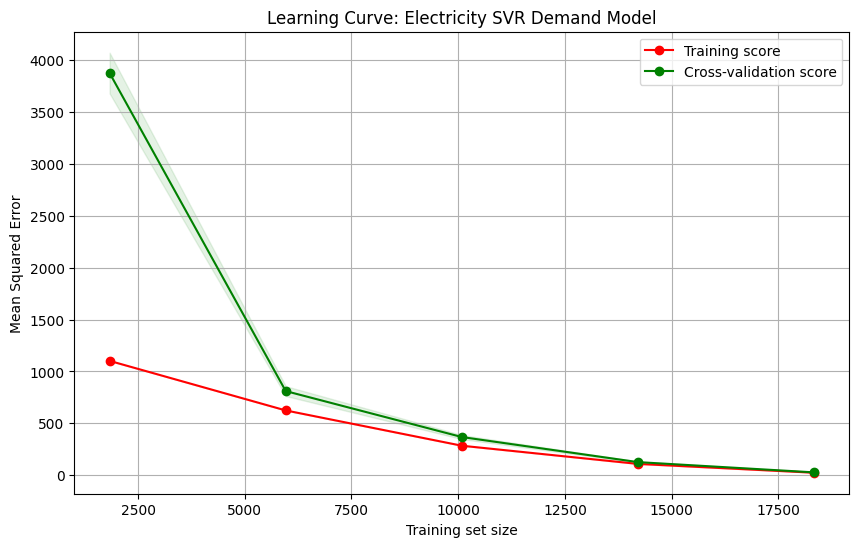

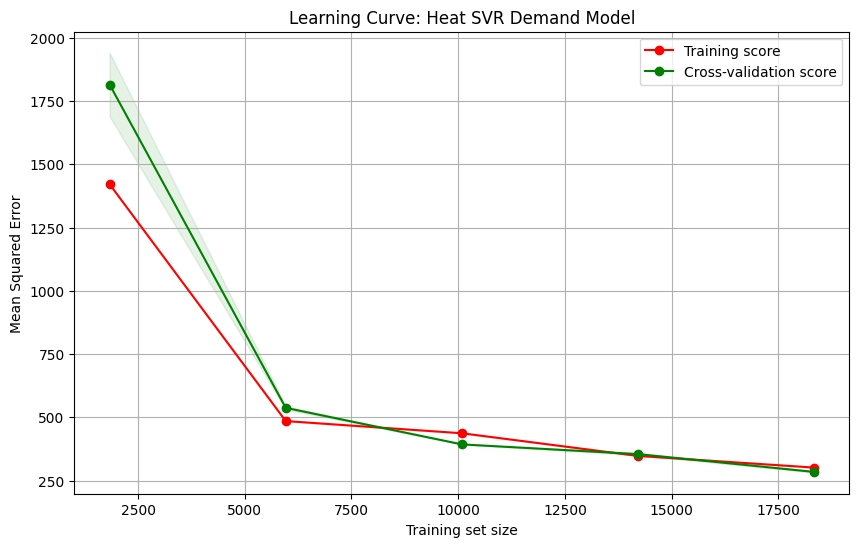

In [9]:
#Plot learning curve 

from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error, make_scorer
import matplotlib.pyplot as plt

def plot_learning_curve(name, model, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=5):
    mse_scorer = make_scorer(mean_squared_error)
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator=model, X=X, y=y, train_sizes=train_sizes, cv=cv, scoring=mse_scorer
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.xlabel("Training set size")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Learning Curve: {name} Demand Model")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Example usage for electricity and heat demand
for best_model, X_train_filtered, y_train in zip(best_models, [X_train_filtered_electricity, X_train_filtered_heat], [y_electricity_train, y_heat_train]):
    plot_learning_curve(best_model["name"], best_model['model'], X_train_filtered, y_train, cv=tscv)

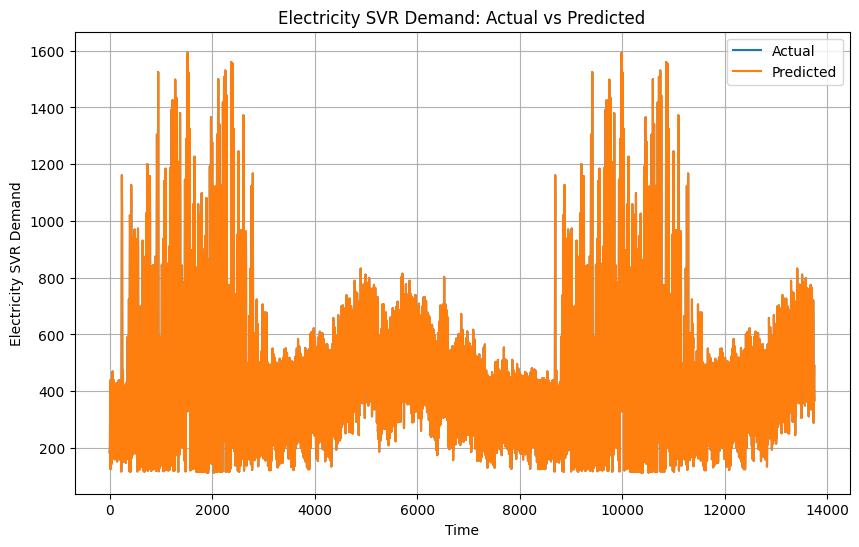

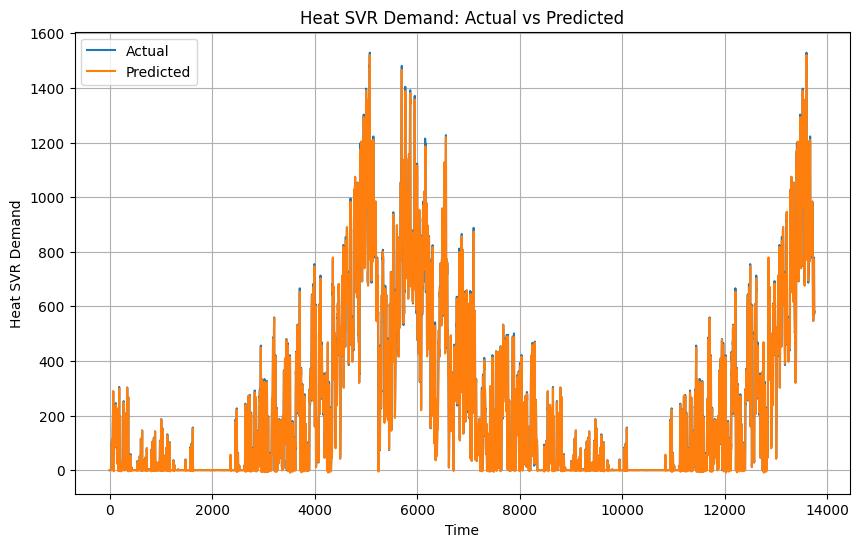

In [10]:
def plot_actual_vs_predicted(name, model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)

   
    y_test_pred = model.predict(X_test)

    
    plt.figure(figsize=(10, 6))
    plt.plot(X_test.index, y_test, label='Actual')
    plt.plot(X_test.index, y_test_pred, label='Predicted')

  
    plt.xlabel('Time')
    plt.ylabel(f'{name} Demand')
    plt.title(f'{name} Demand: Actual vs Predicted')
    plt.legend()
    plt.grid()
    plt.show()


for best_model, X_train_filtered, y_train, X_test_filtered, y_test in zip(best_models, [X_train_filtered_electricity, X_train_filtered_heat], [y_electricity_train, y_heat_train], [X_test_filtered_electricity, X_test_filtered_heat], [y_electricity_test, y_heat_test]):
    plot_actual_vs_predicted(best_model["name"], best_model['model'], X_train_filtered, y_train, X_test_filtered, y_test)


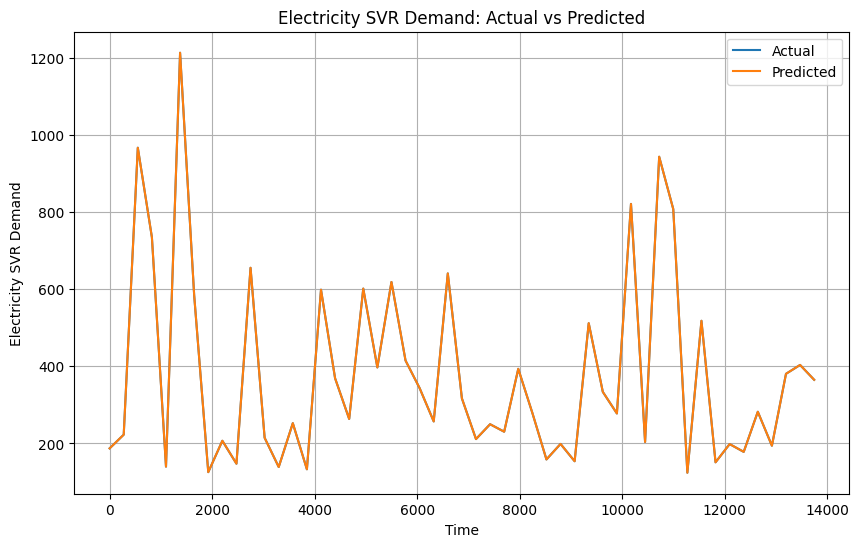

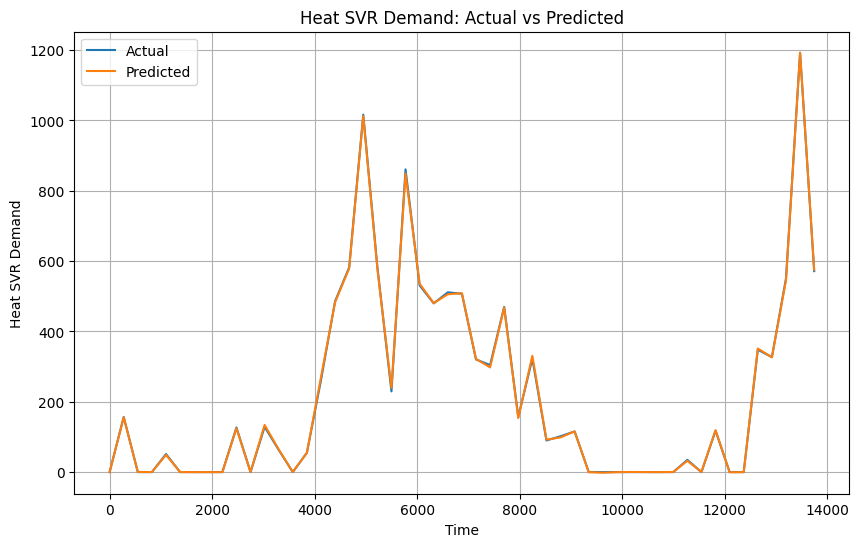

In [11]:
def plot_actual_vs_predicted(name, model, X_train, y_train, X_test, y_test):
   
    model.fit(X_train, y_train)

    
    y_test_pred = model.predict(X_test)

   
    n = max(len(X_test.index) // 50, 1)
    x = X_test.index[::n]

   
    plt.figure(figsize=(10, 6))
    plt.plot(x, y_test[::n], label='Actual')
    plt.plot(x, y_test_pred[::n], label='Predicted')

    
    plt.xlabel('Time')
    plt.ylabel(f'{name} Demand')
    plt.title(f'{name} Demand: Actual vs Predicted')
    plt.legend()
    plt.grid()
    plt.show()

for best_model, X_train_filtered, y_train, X_test_filtered, y_test in zip(best_models, [X_train_filtered_electricity, X_train_filtered_heat], [y_electricity_train, y_heat_train], [X_test_filtered_electricity, X_test_filtered_heat], [y_electricity_test, y_heat_test]):
    plot_actual_vs_predicted(best_model["name"], best_model['model'], X_train_filtered, y_train, X_test_filtered, y_test)
